In [119]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import random 

In [120]:
names = open('names.txt').read().splitlines()

In [121]:
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [122]:
chars = set(''.join(names))
chars.add('.')
n_chars = len(chars)

stoi = {s:i for i,s in enumerate(sorted(chars))}
itos = {i:s for s,i in stoi.items()}

In [123]:
WINDOW_SIZE = 3
def generate_data_examples(name_list):
    X, Y = [], []

    for name in name_list:

        context = [ stoi['.'] ] * WINDOW_SIZE
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [124]:
random.shuffle(names)
n1, n2 = int(0.8*len(names)), int(0.9*len(names))
Xtr, Ytr = generate_data_examples(names[:n1])
Xdev, Ydev = generate_data_examples(names[n1:n2])
Xtest, Ytest = generate_data_examples(names[n2:])

torch.Size([182706, 3]) torch.Size([182706])
torch.Size([22803, 3]) torch.Size([22803])
torch.Size([22637, 3]) torch.Size([22637])


In [125]:
EMBEDDING_DIMENSIONALITY = 10
NUM_NEURONS = 200

In [170]:
g = torch.Generator().manual_seed(2147483647)

# Embedding matrix, 2d vector space to embed the 27-dimensional character space 
C = torch.randn((n_chars, EMBEDDING_DIMENSIONALITY), generator=g)

# first layer of weights and biases
W1 = torch.randn((WINDOW_SIZE * EMBEDDING_DIMENSIONALITY, NUM_NEURONS), generator=g) * 0.15
b1 = torch.randn(NUM_NEURONS, generator=g) * 0.01 # if we use batch normalization, b1 is not needed.
# output layer
W2 = torch.randn(NUM_NEURONS, n_chars, generator=g) * 0.01
b2 = torch.randn(n_chars, generator=g) * 0

bnorm_gain = torch.ones((1, NUM_NEURONS))
bnorm_bias = torch.zeros((1, NUM_NEURONS))

bnorm_mean_cumul = torch.zeros((1, NUM_NEURONS)) # at initialization we should have a gaussian with zero mean
bnorm_std_cumul = torch.ones((1, NUM_NEURONS)) # at initialization we should have a gaussian with unit variance

parameters = [C, W1, b1, W2, b2, bnorm_gain, bnorm_bias]
for p in parameters:
    p.requires_grad = True

In [171]:
sum(p.nelement() for p in parameters)

12297

In [172]:
lossi = []

### With batch normalization. Should be avoided if at all possible, since it ontroduces crosstalk between training examples. 

In [173]:
N_EPOCHS = 200000
BATCH_SIZE = 32
PRINT_EVERY = 10000
BNORM_MOMENTUM = 0.001

for iEpoch in range(N_EPOCHS):

    lr = 0.1 if iEpoch < N_EPOCHS/2 else 0.01
    
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # embed
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # calculate the hidden layer
    preact = emb.view(-1, WINDOW_SIZE * EMBEDDING_DIMENSIONALITY) @ W1 + b1
    
    batch_mean = preact.mean(0, keepdim=True)
    batch_std = preact.std(0, keepdim=True)
    
    preact = bnorm_gain * (preact - batch_mean)/batch_std + bnorm_bias
    
    with torch.no_grad():
        bnorm_mean_cumul = (1 - BNORM_MOMENTUM) * bnorm_mean_cumul + BNORM_MOMENTUM * batch_mean
        bnorm_std_cumul = (1 - BNORM_MOMENTUM) * bnorm_std_cumul + BNORM_MOMENTUM * batch_std
    
    h = torch.tanh(preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data += -lr * p.grad  
    lossi.append(loss.item())
    # track stats:
    if iEpoch % PRINT_EVERY == 0:
        print(f'{iEpoch:7d}/{N_EPOCHS}: {loss.item()}')
    
print(loss.item())

      0/200000: 3.3231351375579834
  10000/200000: 2.7319886684417725
  20000/200000: 2.169313430786133
  30000/200000: 2.116922616958618
  40000/200000: 1.8725647926330566
  50000/200000: 2.093561887741089
  60000/200000: 2.180879831314087
  70000/200000: 2.1506011486053467
  80000/200000: 2.495192289352417
  90000/200000: 2.2717697620391846
 100000/200000: 2.1722166538238525
 110000/200000: 2.0736310482025146
 120000/200000: 2.211246967315674
 130000/200000: 2.2153942584991455
 140000/200000: 1.6626657247543335
 150000/200000: 2.173419952392578
 160000/200000: 2.4825494289398193
 170000/200000: 2.1596603393554688
 180000/200000: 1.7272546291351318
 190000/200000: 1.912085771560669
2.1447594165802


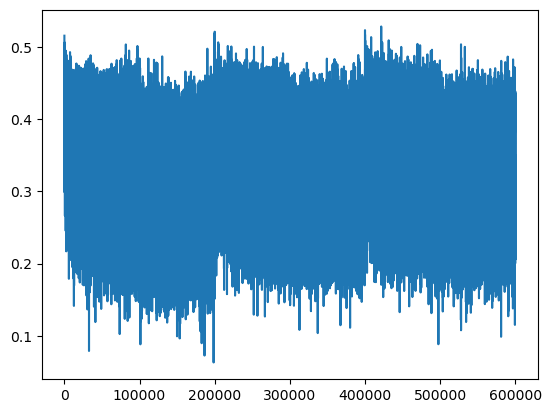

In [142]:
plt.plot(torch.arange(len(lossi)), torch.tensor(lossi).log10())

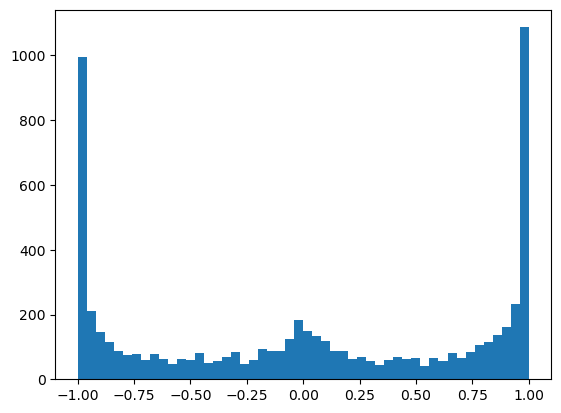

In [117]:
plt.hist(h.view(-1).tolist(), bins=50);

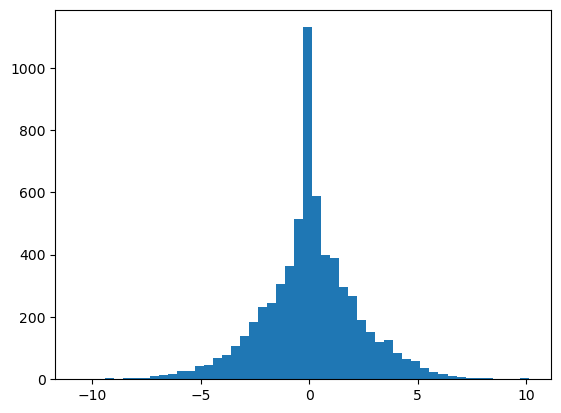

In [118]:
plt.hist(preact.view(-1).tolist(), bins=50);

#### Instead of tracking the means and stds beside the training, one could compute them after the fact for the entire training set

In [174]:
with torch.no_grad():
    emb = C[Xtr]
    preact = emb.view(emb.shape[0], -1) @ W1 + b1
    
    training_mean = preact.mean(0, keepdim=True)
    training_std = preact.std(0, keepdim=True)

In [177]:
@torch.no_grad()
def evaluate_split(split):
    x, y = {'training': (Xtr, Ytr),
            'development': (Xdev, Ydev),
            'test': (Xtest, Ytest)}[split]
    emb = C[x]
    # calculate the hidden layer*
    preact = emb.view(-1, WINDOW_SIZE * EMBEDDING_DIMENSIONALITY) @ W1 + b1
    preact = bnorm_gain * (preact - bnorm_mean_cumul)/bnorm_std_cumul + bnorm_bias
    h = torch.tanh(preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')
    
evaluate_split('training')
evaluate_split('development')

training loss: 2.0599398612976074
development loss: 2.1064348220825195


### Sampling

In [181]:
N_PREDICTIONS = 20

for iPred in range(N_PREDICTIONS):
    
    prediction = ''
    context = [0]*WINDOW_SIZE
    while True:
        emb = C[context]
        preact = emb.view(-1, WINDOW_SIZE * EMBEDDING_DIMENSIONALITY) @ W1 + b1
        preact = bnorm_gain * (preact - bnorm_mean_cumul)/bnorm_std_cumul + bnorm_bias
        h = torch.tanh(preact)
        ix = torch.distributions.Categorical(logits = h @ W2 + b2).sample().item()
        if ix == 0:
            break
        context = context[1:] + [ix]
        prediction += itos[ix]
    print(prediction)

maghal
anxamella
ailah
kenlee
zode
amith
son
yah
haydeh
zayden
nylandreylin
krie
skylee
irae
edi
ara
makarey
joverielanuel
norrina
emmeremaristyn


In [ ]:
# skylee, kenlee, nylandreylin

# Torchifying the code a bit

In [387]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [330]:
WINDOW_SIZE = 3
EMBEDDING_DIMENSIONALITY = 10
NUM_NEURONS = 100

g = torch.Generator().manual_seed(2147483647)

# Embedding matrix, 2d vector space to embed the 27-dimensional character space 
C = torch.randn((n_chars, EMBEDDING_DIMENSIONALITY), generator=g)

layers = [Linear(WINDOW_SIZE*EMBEDDING_DIMENSIONALITY, NUM_NEURONS), Tanh(),
          Linear(NUM_NEURONS, NUM_NEURONS), Tanh(),
          Linear(NUM_NEURONS, NUM_NEURONS), Tanh(),
          Linear(NUM_NEURONS, NUM_NEURONS), Tanh(),
          Linear(NUM_NEURONS, NUM_NEURONS), Tanh(),
          Linear(NUM_NEURONS, n_chars)]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=  5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [331]:
N_EPOCHS = 200000
BATCH_SIZE = 32
PRINT_EVERY = 10000

ud = []
losses = []
for iEpoch in range(N_EPOCHS):   
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # embed
    emb = C[Xb]
    X = emb.view(BATCH_SIZE, -1)
    for layer in layers:
        X = layer(X)
    loss = F.cross_entropy(X, Yb)
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if iEpoch < N_EPOCHS/2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad  
    losses.append(loss.item())
    
    # track stats:
    if iEpoch % PRINT_EVERY == 0:
        print(f'{iEpoch:7d}/{N_EPOCHS}: {loss.item()}')
    
    with torch.no_grad():
        ud.append([ (lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if iEpoch >= 1000:
        break
    
print(loss.item())

      0/200000: 3.286109447479248
2.3817081451416016


Layer: 1: Tanh, mean: -0.04, std: 0.77, % saturation: 22.88%
Layer: 3: Tanh, mean: -0.01, std: 0.72, % saturation: 12.69%
Layer: 5: Tanh, mean: 0.01, std: 0.73, % saturation: 11.84%
Layer: 7: Tanh, mean: -0.04, std: 0.73, % saturation: 12.78%
Layer: 9: Tanh, mean: -0.03, std: 0.71, % saturation: 11.19%


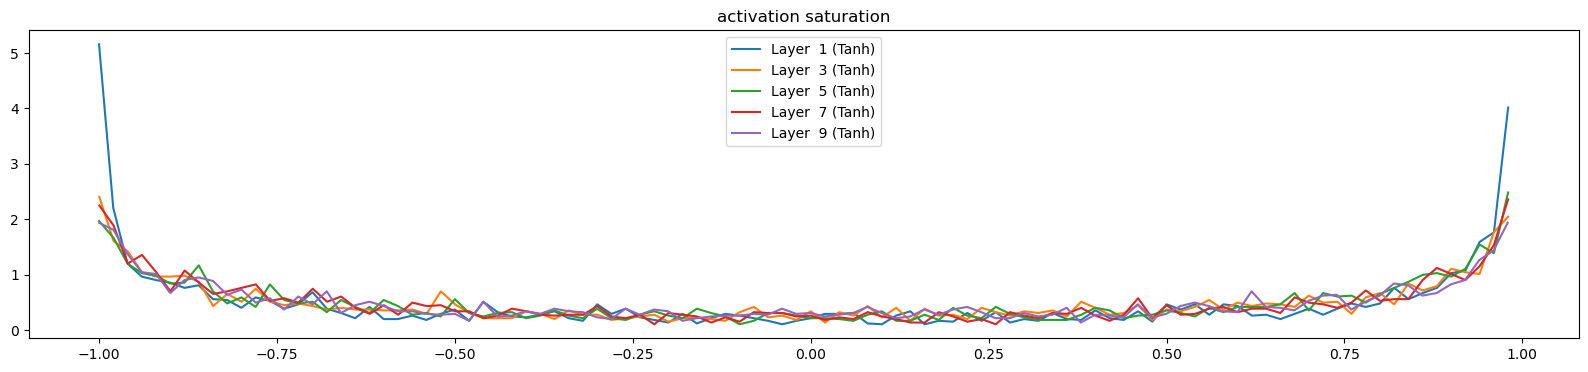

In [332]:
plt.figure(figsize=(20,4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'Layer: {i}: {layer.__class__.__name__}, mean: {t.mean():.2f}, std: {t.std():.2f}, % saturation: {100*torch.sum(torch.abs(t) > 0.97)/t.nelement():.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer  {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation saturation');
plt.show();

Layer: 1: Tanh, mean: -1.395e-04, std: 3.639e-03
Layer: 3: Tanh, mean: -3.426e-05, std: 3.314e-03
Layer: 5: Tanh, mean: 7.351e-05, std: 3.068e-03
Layer: 7: Tanh, mean: 2.034e-05, std: 3.008e-03
Layer: 9: Tanh, mean: 1.548e-05, std: 2.432e-03


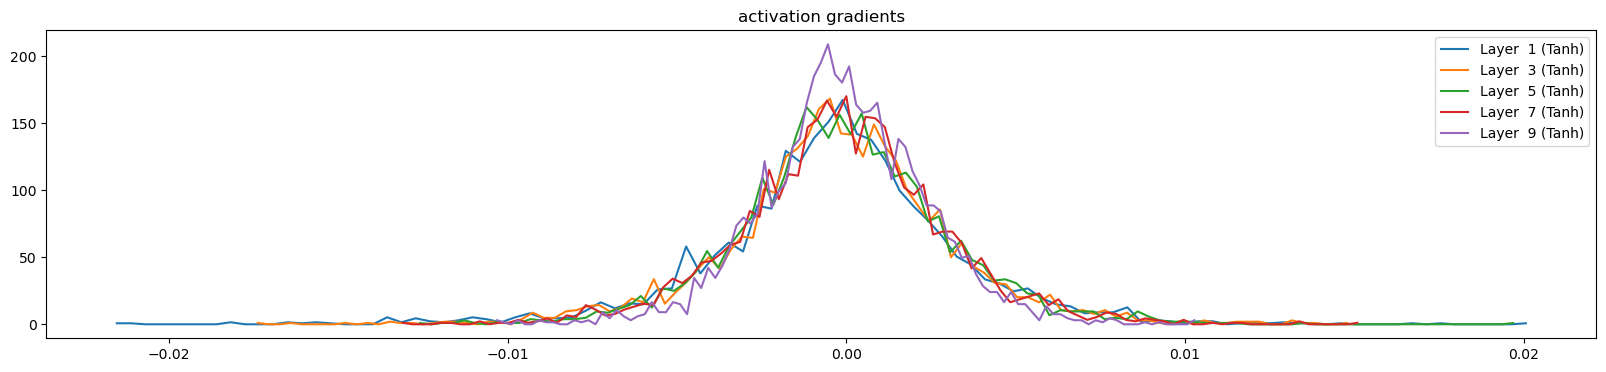

In [333]:
plt.figure(figsize=(20,4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'Layer: {i}: {layer.__class__.__name__}, mean: {t.mean():.3e}, std: {t.std():.3e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer  {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation gradients');
plt.show();

Layer: 0: Linear, mean: -0.08811, std: 1.72591
Layer: 2: Linear, mean: -0.03216, std: 1.36477
Layer: 4: Linear, mean: 0.03957, std: 1.40017
Layer: 6: Linear, mean: -0.05467, std: 1.37862
Layer: 8: Linear, mean: -0.05244, std: 1.32313


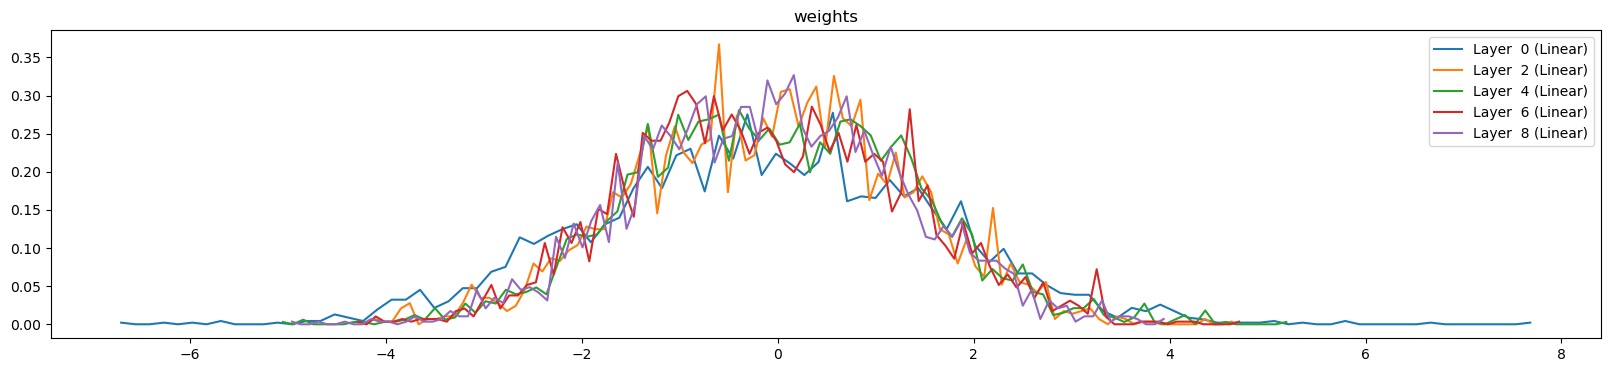

In [334]:
plt.figure(figsize=(20,4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out
        print(f'Layer: {i}: {layer.__class__.__name__}, mean: {t.mean():.5f}, std: {t.std():.5f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer  {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('weights')
plt.show();

Layer: 0: Linear, mean: -9.156e-05, std: 2.055e-03
Layer: 2: Linear, mean: 1.240e-05, std: 2.036e-03
Layer: 4: Linear, mean: 3.832e-05, std: 1.777e-03
Layer: 6: Linear, mean: 4.109e-05, std: 1.689e-03
Layer: 8: Linear, mean: 9.272e-06, std: 1.426e-03


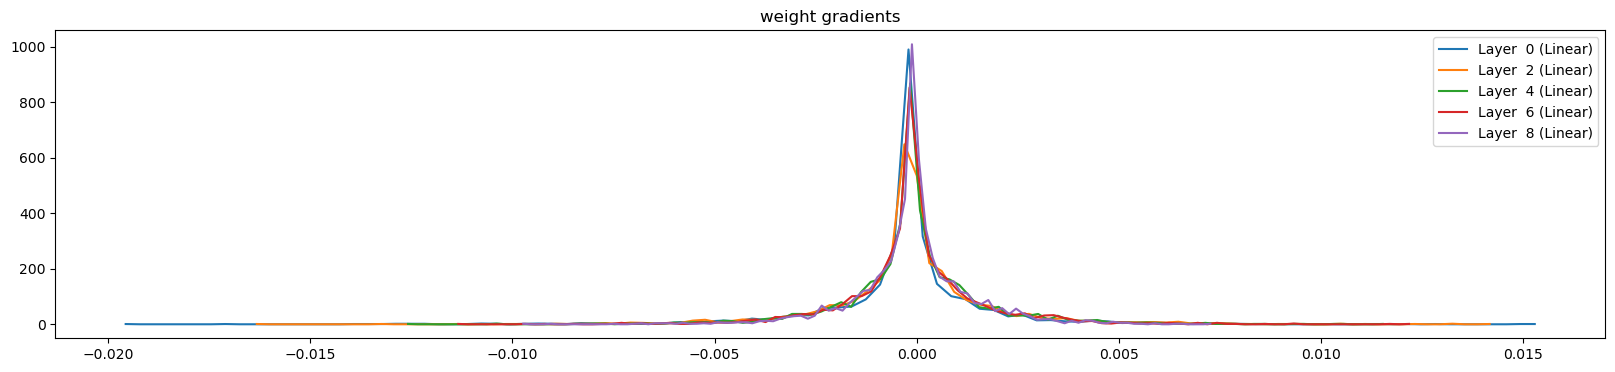

In [335]:
plt.figure(figsize=(20,4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out.grad
        print(f'Layer: {i}: {layer.__class__.__name__}, mean: {t.mean():.3e}, std: {t.std():.3e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer  {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('weight gradients');
plt.show();

Size: (27, 10), mean: 1.798e-04, std: 1.459e-02, grad:data ratio: 1.46e-02
Size: (30, 100), mean: -8.756e-05, std: 1.267e-02, grad:data ratio: 4.05e-02
Size: (100, 100), mean: -2.310e-06, std: 9.128e-03, grad:data ratio: 5.43e-02
Size: (100, 100), mean: 1.266e-04, std: 7.561e-03, grad:data ratio: 4.46e-02
Size: (100, 100), mean: -3.558e-05, std: 7.779e-03, grad:data ratio: 4.61e-02
Size: (100, 100), mean: 1.568e-05, std: 6.867e-03, grad:data ratio: 4.08e-02
Size: (100, 27), mean: 1.656e-11, std: 2.312e-02, grad:data ratio: 3.33e-01


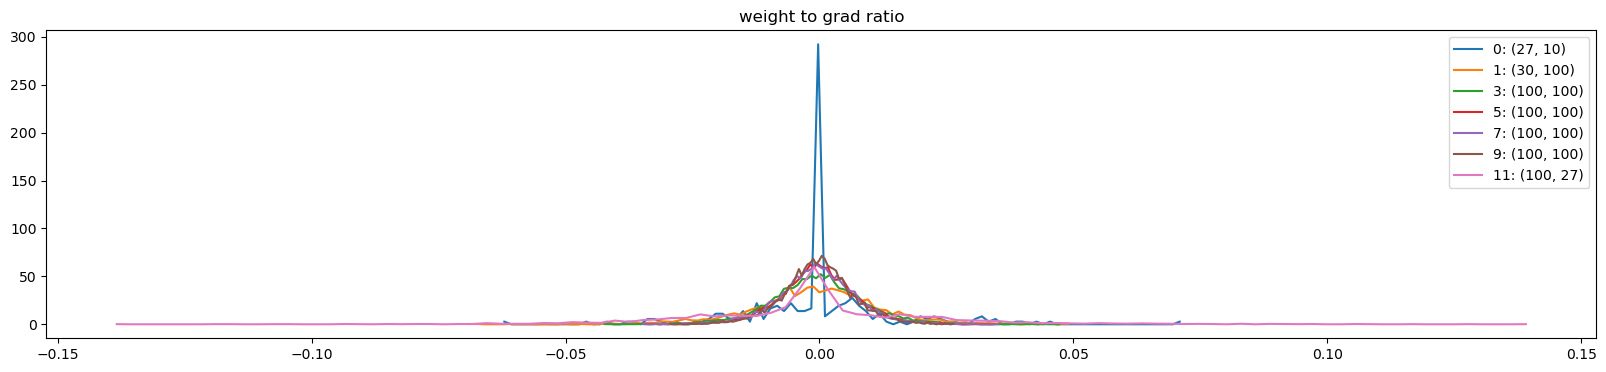

In [336]:
plt.figure(figsize=(20,4));
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if t.ndim == 2:
        print(f'Size: {tuple(p.shape)}, mean: {t.mean():.3e}, std: {t.std():.3e}, grad:data ratio: {t.std() / p.std():.2e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i}: {tuple(t.shape)}')
plt.legend(legends)
plt.title('weight to grad ratio');
plt.show();

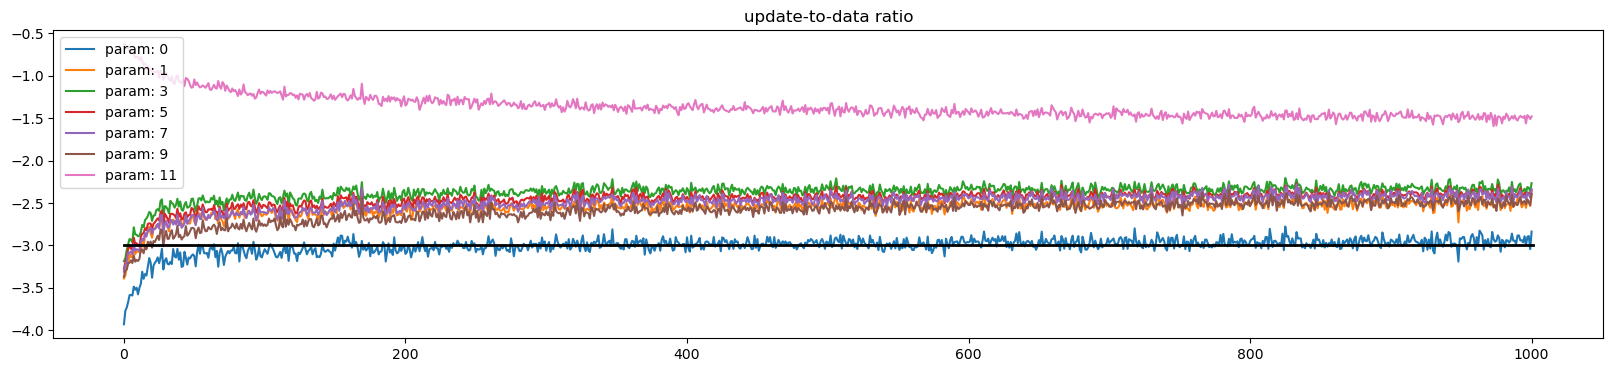

In [337]:
plt.figure(figsize=(20,4));
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param: {i}')
plt.plot([0, len(ud)], [-3, -3], 'k', linewidth=2)
plt.legend(legends)
plt.title('update-to-data ratio');
plt.show();

# Reintroduce BatchNorm

In [372]:
class BatchNorm1d:
    def __init__(self, n_features, eps=1e-5, momentum=0.1, track_running_stats=True):
        self.eps = eps
        self.momentum = momentum
        self.track_running_stats = track_running_stats
        
        # when the layer is initialized, it is training
        self.training = True
    
        self.gamma = torch.ones(n_features)
        self.beta = torch.zeros(n_features)
        
        if track_running_stats:
            self.running_mean = torch.zeros(n_features)
            self.running_var = torch.ones(n_features)
            
    def __call__(self, x):
        
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        
        self.out = (x - x_mean)/torch.sqrt(x_var + self.eps) * self.gamma + self.beta
        
        if self.track_running_stats and self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum * x_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

In [388]:
WINDOW_SIZE = 3
EMBEDDING_DIMENSIONALITY = 10
NUM_NEURONS = 100

g = torch.Generator().manual_seed(2147483647)

# Embedding matrix, 2d vector space to embed the 27-dimensional character space 
C = torch.randn((n_chars, EMBEDDING_DIMENSIONALITY), generator=g)

layers = [Linear(WINDOW_SIZE*EMBEDDING_DIMENSIONALITY, NUM_NEURONS), BatchNorm1d(NUM_NEURONS), Tanh(),
          Linear(NUM_NEURONS, NUM_NEURONS), BatchNorm1d(NUM_NEURONS), Tanh(),
          Linear(NUM_NEURONS, NUM_NEURONS), BatchNorm1d(NUM_NEURONS), Tanh(),
          Linear(NUM_NEURONS, NUM_NEURONS), BatchNorm1d(NUM_NEURONS), Tanh(),
          Linear(NUM_NEURONS, NUM_NEURONS), BatchNorm1d(NUM_NEURONS), Tanh(),
          Linear(NUM_NEURONS, n_chars), BatchNorm1d(n_chars)]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    
    # with batch-norm we don't need to set the gains
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *=  5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [389]:
N_EPOCHS = 200000
BATCH_SIZE = 32
PRINT_EVERY = 10000

ud = []
losses = []
for iEpoch in range(N_EPOCHS):   
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # embed
    emb = C[Xb]
    X = emb.view(BATCH_SIZE, -1)
    for layer in layers:
        X = layer(X)
    loss = F.cross_entropy(X, Yb)
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if iEpoch < N_EPOCHS/2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad  
    losses.append(loss.item())
    
    # track stats:
    if iEpoch % PRINT_EVERY == 0:
        print(f'{iEpoch:7d}/{N_EPOCHS}: {loss.item()}')
    
    with torch.no_grad():
        ud.append([ (lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if iEpoch >= 1000:
        break
    
print(loss.item())

      0/200000: 3.2792060375213623
2.8522729873657227


Layer: 2: Tanh, mean: -0.00, std: 0.64, % saturation: 2.97%
Layer: 5: Tanh, mean: 0.00, std: 0.64, % saturation: 2.19%
Layer: 8: Tanh, mean: 0.00, std: 0.65, % saturation: 2.16%
Layer: 11: Tanh, mean: 0.00, std: 0.65, % saturation: 2.09%
Layer: 14: Tanh, mean: -0.00, std: 0.64, % saturation: 2.31%


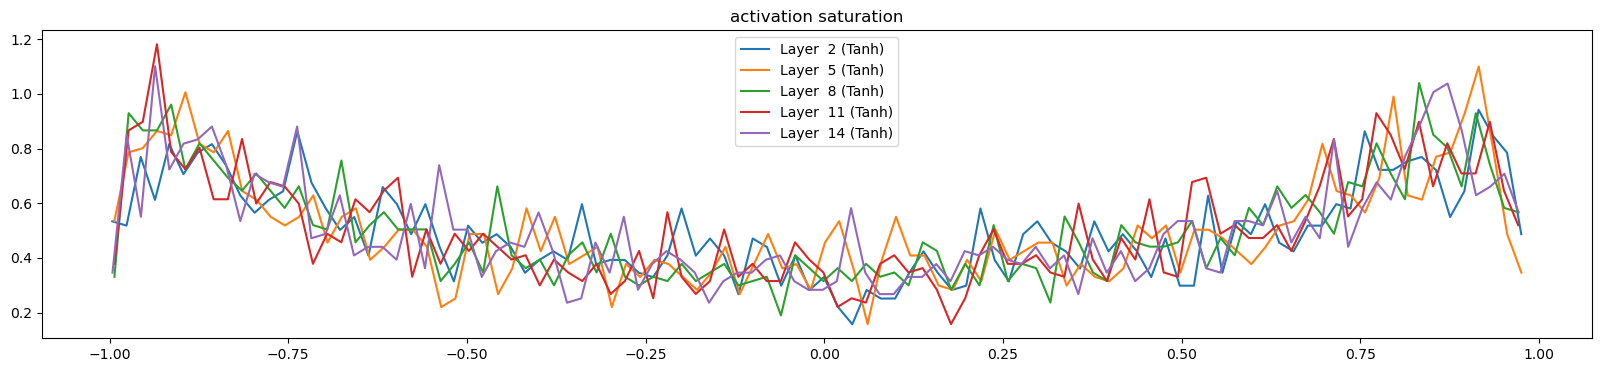

In [390]:
plt.figure(figsize=(20,4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'Layer: {i}: {layer.__class__.__name__}, mean: {t.mean():.2f}, std: {t.std():.2f}, % saturation: {100*torch.sum(torch.abs(t) > 0.97)/t.nelement():.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer  {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation saturation');
plt.show();

Layer: 2: Tanh, mean: -1.601e-11, std: 2.381e-03
Layer: 5: Tanh, mean: 0.000e+00, std: 1.983e-03
Layer: 8: Tanh, mean: -3.492e-12, std: 1.944e-03
Layer: 11: Tanh, mean: 9.895e-12, std: 1.818e-03
Layer: 14: Tanh, mean: -4.366e-12, std: 1.972e-03


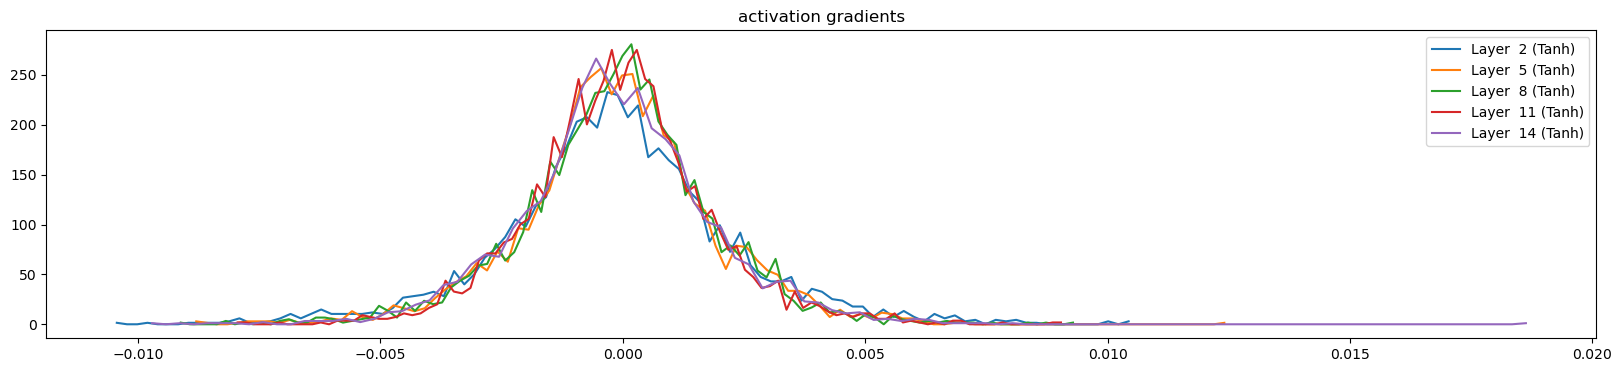

In [391]:
plt.figure(figsize=(20,4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'Layer: {i}: {layer.__class__.__name__}, mean: {t.mean():.3e}, std: {t.std():.3e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer  {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation gradients');
plt.show();

Layer: 0: Linear, mean: -0.03430, std: 1.06903
Layer: 3: Linear, mean: -0.00060, std: 0.70443
Layer: 6: Linear, mean: 0.00580, std: 0.78614
Layer: 9: Linear, mean: -0.00397, std: 0.76451
Layer: 12: Linear, mean: 0.00397, std: 0.80949
Layer: 15: Linear, mean: -0.00824, std: 1.11807


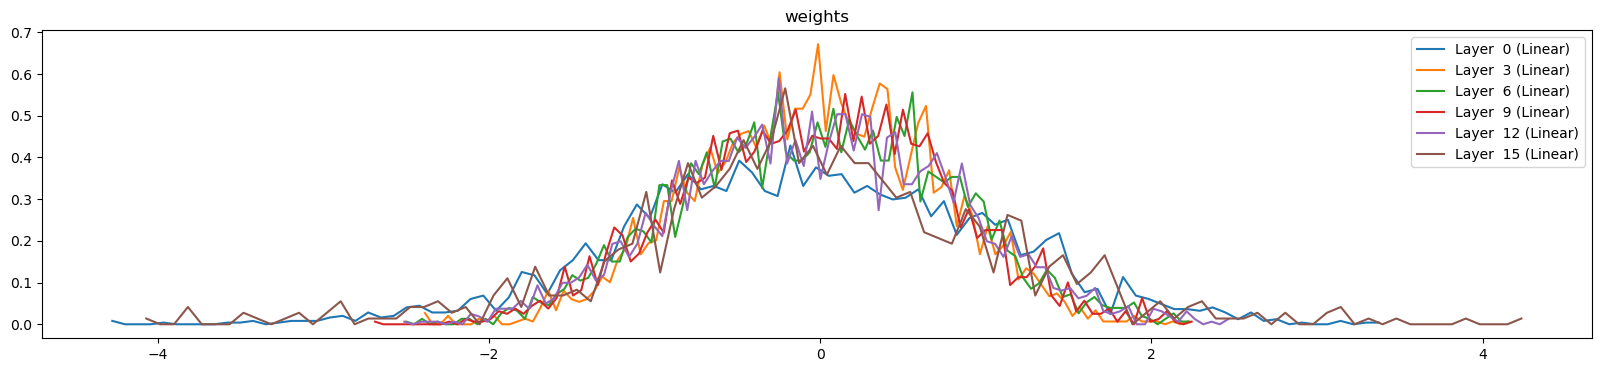

In [392]:
plt.figure(figsize=(20,4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out
        print(f'Layer: {i}: {layer.__class__.__name__}, mean: {t.mean():.5f}, std: {t.std():.5f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer  {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('weights')
plt.show();

Layer: 0: Linear, mean: 4.657e-12, std: 1.745e-03
Layer: 3: Linear, mean: 8.731e-13, std: 1.971e-03
Layer: 6: Linear, mean: -3.492e-12, std: 1.666e-03
Layer: 9: Linear, mean: 7.567e-12, std: 1.643e-03
Layer: 12: Linear, mean: 5.821e-13, std: 1.594e-03
Layer: 15: Linear, mean: -1.940e-11, std: 3.479e-03


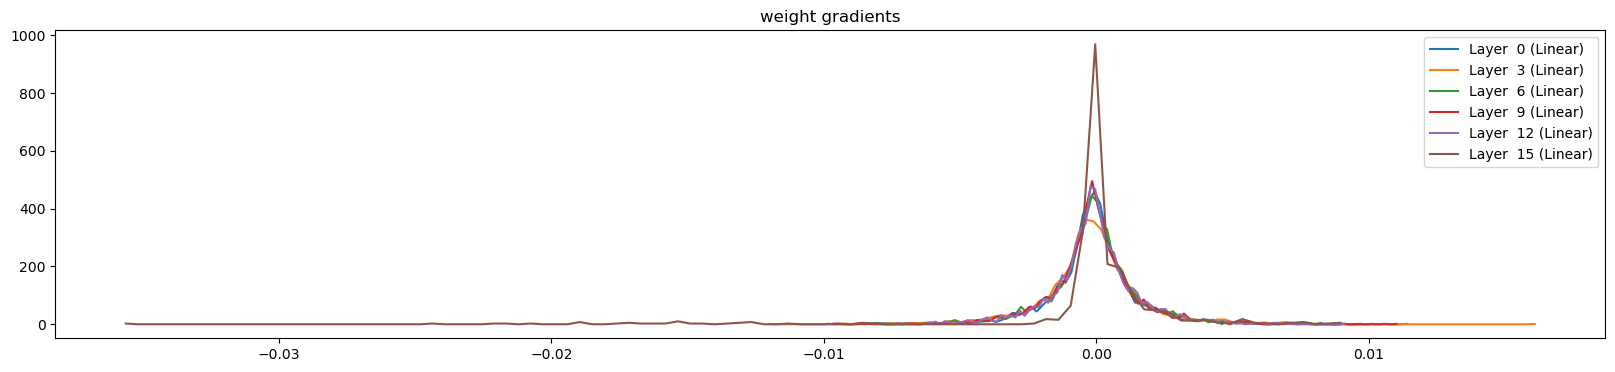

In [393]:
plt.figure(figsize=(20,4));
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out.grad
        print(f'Layer: {i}: {layer.__class__.__name__}, mean: {t.mean():.3e}, std: {t.std():.3e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer  {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('weight gradients');
plt.show();

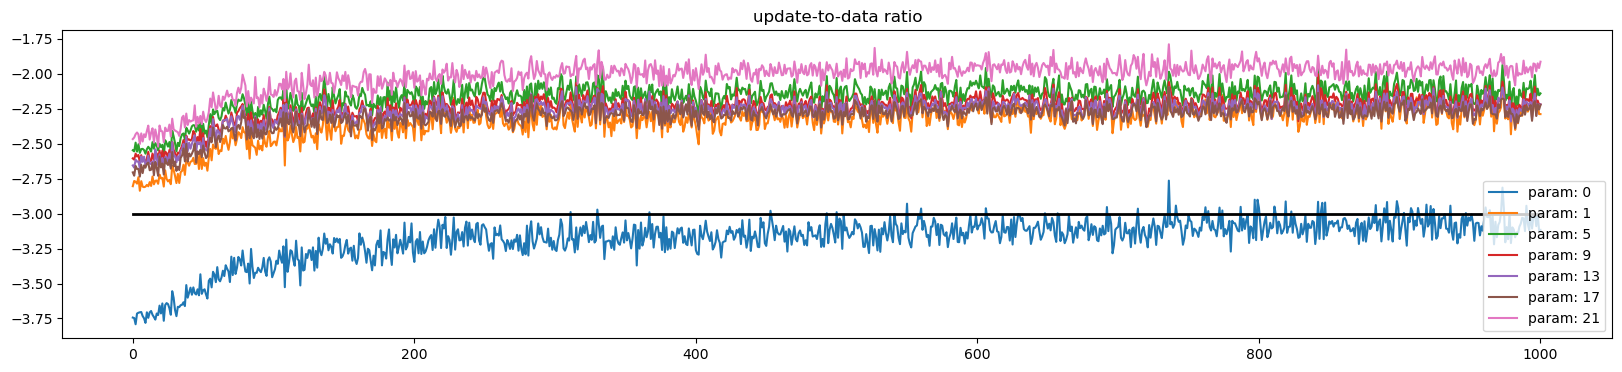

In [394]:
plt.figure(figsize=(20,4));
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param: {i}')
plt.plot([0, len(ud)], [-3, -3], 'k', linewidth=2)
plt.legend(legends)
plt.title('update-to-data ratio');
plt.show();